# Segment 0


In [ ]:
# Cell 1: Setup Chromium and Kaleido
!apt-get update
!apt-get install -y chromium-browser chromium-chromedriver
!pip install -U kaleido==0.2.1 plotly==5.15.0

import os
os.environ['KALEIDO_BROWSER'] = '/usr/bin/chromium-browser'
os.environ['KALEIDO_CHROMIUM_PATH'] = '/usr/bin/chromium-browser'

print("Setup complete! Please RESTART RUNTIME from the menu: Runtime → Restart runtime")

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://cli.github.com/packages stable InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,942 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,20

# Segment 1


In [ ]:
# Segment 1: Enhanced Imports and Configuration
import plotly.io as pio
pio.kaleido.scope.mathjax = None


!pip install yfinance pandas numpy requests nltk scikit-learn hmmlearn tensorflow matplotlib seaborn newsapi-python finnhub-python alpha_vantage gdown bayesian-optimization fredapi

import os
import time
import json
import sqlite3
import gzip
import pickle
import warnings
warnings.filterwarnings('ignore')

import yfinance as yf
import pandas as pd
import numpy as np
import requests
import re
import nltk
from datetime import datetime, timedelta
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from hmmlearn import hmm
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import (Input, LSTM, Dense, Dropout, Attention,
                                    Concatenate, Multiply, Bidirectional,
                                    LayerNormalization, Conv1D, MaxPooling1D,
                                    Flatten, Reshape, MultiHeadAttention)
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau,
                                      ModelCheckpoint, LearningRateScheduler)
from tensorflow.keras.regularizers import l1_l2, l2
from tensorflow.keras.losses import Huber
from tensorflow.keras.metrics import RootMeanSquaredError
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import newsapi
from newsapi import NewsApiClient
import finnhub
from alpha_vantage.timeseries import TimeSeries
import tensorflow as tf
from fredapi import Fred
from bayes_opt import BayesianOptimization
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon', quiet=True)
nltk.download('punkt', quiet=True)

class Config:
    # API Configuration (replace with your keys)
    NEWSAPI_KEY = "4312ff99f09749139d66a3af1a9eeb2"
    FINNHUB_KEY = "d1lufjhr01qg4dblf94gd1lufjhr01qg4dblf950"
    ALPHA_VANTAGE_KEY = "I4UDMI1QFPHDANQJ"
    REDDIT_CLIENT_ID = "mqilmYgAmSWlrwFvnAtmNg"
    REDDIT_CLIENT_SECRET = "    7SwpOHO5tL0jsq_zCqEX8FOpRe4O5w"
    REDDIT_USER_AGENT = "StockPredictorV2"
    TWITTER_BEARER_TOKEN = "your_twitter_token"
    FRED_API_KEY = "6c409f74d707bbea020297b6244536ee "

    # Model parameters
    YEARS_OF_HISTORY = 3  # Increased historical data
    LOOKBACK_WINDOW = 30  # Longer lookback window
    PREDICTION_HORIZON = 10  # Predict 10 days by default
    TEST_SIZE = 0.15
    MC_DROPOUT_SAMPLES = 50  # For uncertainty estimation

    LSTM_UNITS = 320
    TRANSFORMER_HEADS = 8
    TRANSFORMER_DIM = 64
    DROPOUT_RATE = 0.4
    L1_L2_REG = (1e-6, 1e-5)  # Reduced regularization
    LEARNING_RATE = 0.00005
    BATCH_SIZE = 64
    EPOCHS = 250
    PATIENCE = 20
    QUANTILES = [0.05, 0.25, 0.5, 0.75, 0.95]  # More quantiles

    # Feature toggles
    USE_TECHNICAL_INDICATORS = True
    USE_NEWS_SENTIMENT = True
    USE_REDDIT_SENTIMENT = True
    USE_TWITTER_SENTIMENT = True
    USE_ANALYST_RATINGS = True
    USE_MACRO_DATA = True
    USE_REGIME_DETECTION = True
    USE_ALTERNATIVE_DATA = True
    USE_WAVELET_FEATURES = True

    MAX_WORKERS = 8
    DATA_DIR = "financial_data"
    DB_PATH = f"{DATA_DIR}/database/finance.db"

# Create directories
os.makedirs(f"{Config.DATA_DIR}/database", exist_ok=True)
os.makedirs(f"{Config.DATA_DIR}/news", exist_ok=True)
os.makedirs(f"{Config.DATA_DIR}/stocks", exist_ok=True)
os.makedirs(f"{Config.DATA_DIR}/company_info", exist_ok=True)
os.makedirs(f"{Config.DATA_DIR}/financials", exist_ok=True)
os.makedirs(f"{Config.DATA_DIR}/alternative_data", exist_ok=True)
os.makedirs(f"{Config.DATA_DIR}/plots", exist_ok=True)

# Segment 2


In [ ]:
# Segment 2: Enhanced Data Collector
!pip install praw
import praw
import pywt
class DataCollector:
    def __init__(self):
        self.analyst_cache = {}
        self.macro_cache = {}
        self.fred = Fred(api_key=Config.FRED_API_KEY) if Config.FRED_API_KEY != "your_fred_key" else None

        # Initialize APIs
        self.newsapi = NewsApiClient(api_key=Config.NEWSAPI_KEY) if Config.NEWSAPI_KEY != "your_newsapi_key" else None
        self.finnhub = finnhub.Client(api_key=Config.FINNHUB_KEY) if Config.FINNHUB_KEY != "your_finnhub_key" else None
        self.av_client = TimeSeries(key=Config.ALPHA_VANTAGE_KEY, output_format='pandas') if Config.ALPHA_VANTAGE_KEY != "your_alpha_vantage_key" else None

        if (Config.REDDIT_CLIENT_ID != "your_reddit_id" and
            Config.REDDIT_CLIENT_SECRET != "your_reddit_secret"):
            try:
                self.reddit = praw.Reddit(
                    client_id=Config.REDDIT_CLIENT_ID,
                    client_secret=Config.REDDIT_CLIENT_SECRET,
                    user_agent=Config.REDDIT_USER_AGENT,
                    check_for_async=False
                )
            except Exception as e:
                print(f"Failed to initialize PRAW: {e}")
                self.reddit = None
        else:
            self.reddit = None

    def get_stock_data(self, ticker):
        end_date = datetime.now()
        start_date = end_date - timedelta(days=Config.YEARS_OF_HISTORY*365)

        # Get daily data
        daily = yf.download(ticker, start=start_date, end=end_date, progress=False)
        if daily.empty:
            raise ValueError(f"No daily data found for {ticker}")

        # Get hourly data for recent period
        hourly = yf.download(ticker, period="60d", interval="60m", progress=False)

        # --- ROBUST COLUMN NAME HANDLING ---
        if isinstance(daily.columns, pd.MultiIndex):
            daily.columns = daily.columns.get_level_values(0)
        if not hourly.empty and isinstance(hourly.columns, pd.MultiIndex):
            hourly.columns = hourly.columns.get_level_values(0)

        daily.columns = [str(col).lower() for col in daily.columns]
        if not hourly.empty:
            hourly.columns = [str(col).lower() for col in hourly.columns]
        # --- END ROBUST HANDLING ---

        if not hourly.empty:
            hourly_daily = hourly.resample('D').agg({
                'open': 'first', 'high': 'max', 'low': 'min',
                'close': 'last', 'volume': 'sum'
            })
            if daily.index.tz is None and hourly_daily.index.tz is not None:
                daily.index = daily.index.tz_localize(hourly_daily.index.tz)
            combined = pd.concat([daily, hourly_daily]).sort_index()
            combined = combined[~combined.index.duplicated(keep='last')]
        else:
            combined = daily

        combined.columns = [col.capitalize() for col in combined.columns]
        return combined.reset_index().rename(columns={'index': 'date'})


    def get_twitter_sentiment(self, ticker, start_date, end_date):
        # This function is a placeholder as it requires a valid Twitter Bearer Token
        return pd.DataFrame()

    def _fetch_news_articles(self, ticker, start_date, end_date):
        articles = []
        if self.newsapi:
            # Code for fetching news from NewsAPI
            pass
        if self.finnhub:
            # Code for fetching news from Finnhub
            pass
        return articles

    def get_news_sentiment(self, ticker, start_date, end_date):
        # This function relies on API calls that may fail; simplified for now
        return pd.DataFrame(columns=['date', 'compound'])

    def get_reddit_sentiment(self, ticker, start_date, end_date):
        # This function relies on valid Reddit API keys
        if not self.reddit:
            return pd.DataFrame(columns=['date', 'reddit_sentiment'])
        # Simplified to return an empty frame as keys are likely invalid
        return pd.DataFrame(columns=['date', 'reddit_sentiment'])

    def get_analyst_ratings(self, ticker):
        # Simplified analyst ratings logic
        return {}

    def get_macro_data(self, start_date, end_date):
        if 'macro_data' in self.macro_cache:
            return self.macro_cache['macro_data'].copy()

        try:
            date_index = pd.date_range(start=start_date, end=end_date, freq='D')
            macro_df = pd.DataFrame(index=date_index)

            yf_indicators = {
                'vix': '^VIX', 'treasury_10y': '^TNX', 'dollar_index': 'DX-Y.NYB',
                'gold_price': 'GC=F', 'oil_price': 'CL=F'
            }
            for name, yf_ticker in yf_indicators.items():
                try:
                    data = yf.download(yf_ticker, start=start_date, end=end_date, progress=False)['Close']
                    if not data.empty:
                        macro_df[name] = data
                except Exception:
                    macro_df[name] = np.nan

            if self.fred:
                fred_indicators = {
                    'GDP': 'GDP', 'UNRATE': 'Unemployment Rate', 'CPIAUCSL': 'CPI',
                    'FEDFUNDS': 'Fed Funds Rate', 'SP500': 'S&P 500'
                }
                for code, name in fred_indicators.items():
                    try:
                        series = self.fred.get_series(code, start_date, end_date)
                        macro_df[name] = series
                    except Exception:
                        macro_df[name] = np.nan

            macro_df.ffill(inplace=True)
            macro_df.bfill(inplace=True)

            macro_df.reset_index(inplace=True)
            macro_df.rename(columns={'index': 'date'}, inplace=True)

            self.macro_cache['macro_data'] = macro_df
            return macro_df
        except Exception as e:
            print(f"Critical error in get_macro_data: {e}")
            return pd.DataFrame()

# Segment 3

In [ ]:
# Segment 3: Advanced Feature Engineering
class FeatureEngineer:
    def __init__(self, ticker):
        self.ticker = ticker
        self.scaler = RobustScaler()
        self.data_collector = DataCollector()
        self.wavelet = 'db4'
        self.level = 3

    def add_features(self, data):
        # Ensure we have a date column
        if 'date' not in data.columns and 'Date' in data.columns:
            data.rename(columns={'Date': 'date'}, inplace=True)
        data['date'] = pd.to_datetime(data['date'])

        # Convert to timezone-naive to prevent merge errors later
        if data['date'].dt.tz is not None:
            data['date'] = data['date'].dt.tz_localize(None)

        # Add all features
        data = self.add_technical_indicators(data)
        data = self.add_time_features(data)
        data = self.add_sentiment_features(data)
        data = self.add_analyst_features(data)

        if Config.USE_MACRO_DATA:
            data = self.add_macro_features(data)

        if Config.USE_ALTERNATIVE_DATA:
            data = self.add_alternative_data(data)

        if Config.USE_WAVELET_FEATURES:
            data = self.add_wavelet_features(data)

        data.fillna(method='ffill', inplace=True)
        data.fillna(method='bfill', inplace=True)
        data.dropna(inplace=True)

        return data

    def add_wavelet_features(self, data):
        if 'Close' not in data.columns:
            return data

        close = data['Close'].values
        coeffs = pywt.wavedec(close, self.wavelet, level=self.level)

        for i, coeff in enumerate(coeffs):
            if i == 0:  # Approximation coefficients
                col_name = f'wavelet_approx_{self.level}'
                # Ensure we have enough values
                if len(coeff) < len(data):
                    coeff = np.pad(coeff, (0, len(data)-len(coeff)), 'edge')
                data[col_name] = coeff[:len(data)]
            else:  # Detail coefficients
                col_name = f'wavelet_detail_l{i}'
                # Ensure we have enough values
                if len(coeff) < len(data):
                    coeff = np.pad(coeff, (0, len(data)-len(coeff)), 'edge')
                data[col_name] = coeff[:len(data)]
        return data

    def add_technical_indicators(self, data):
        data['returns'] = data['Close'].pct_change()
        data['sma_20'] = data['Close'].rolling(window=20).mean()
        data['sma_50'] = data['Close'].rolling(window=50).mean()
        data['sma_200'] = data['Close'].rolling(window=200).mean()
        data['ema_12'] = data['Close'].ewm(span=12, adjust=False).mean()
        data['ema_26'] = data['Close'].ewm(span=26, adjust=False).mean()
        data['macd'] = data['ema_12'] - data['ema_26']
        data['macd_signal'] = data['macd'].ewm(span=9, adjust=False).mean()
        data['macd_hist'] = data['macd'] - data['macd_signal']

        delta = data['Close'].diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(window=14).mean()
        avg_loss = loss.rolling(window=14).mean()
        rs = avg_gain / avg_loss
        data['rsi'] = 100 - (100 / (1 + rs))

        rolling_std = data['Close'].rolling(window=20).std()
        if isinstance(rolling_std, pd.DataFrame):
            rolling_std = rolling_std.squeeze()
        data['bb_upper'] = data['sma_20'] + (2 * rolling_std)
        data['bb_lower'] = data['sma_20'] - (2 * rolling_std)

        low_min = data['Low'].rolling(window=14).min()
        high_max = data['High'].rolling(window=14).max()
        data['stoch_k'] = 100 * ((data['Close'] - low_min) / (high_max - low_min))
        data['stoch_d'] = data['stoch_k'].rolling(window=3).mean()

        data['obv'] = (np.sign(data['Close'].diff()) * data['Volume']).cumsum()

        # Additional indicators
        data['atr'] = self.calculate_atr(data)
        data['adx'] = self.calculate_adx(data)
        data['cci'] = self.calculate_cci(data)

        data.drop(['ema_12', 'ema_26'], axis=1, inplace=True, errors='ignore')
        return data

    def calculate_atr(self, data, period=14):
        high_low = data['High'] - data['Low']
        high_close = np.abs(data['High'] - data['Close'].shift())
        low_close = np.abs(data['Low'] - data['Close'].shift())
        tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
        return tr.rolling(period).mean()

    def calculate_adx(self, data, period=14):
        plus_dm = data['High'].diff()
        minus_dm = -data['Low'].diff()
        plus_dm[plus_dm < 0] = 0
        minus_dm[minus_dm < 0] = 0

        tr = self.calculate_atr(data, period)
        plus_di = 100 * (plus_dm.ewm(alpha=1/period).mean() / tr)
        minus_di = 100 * (minus_dm.ewm(alpha=1/period).mean() / tr)
        dx = 100 * np.abs((plus_di - minus_di) / (plus_di + minus_di))
        return dx.ewm(alpha=1/period).mean()

    def calculate_cci(self, data, period=20):
        tp = (data['High'] + data['Low'] + data['Close']) / 3
        sma = tp.rolling(period).mean()
        mad = np.abs(tp - sma).rolling(period).mean()
        return (tp - sma) / (0.015 * mad)

    def add_time_features(self, data):
        if 'date' not in data.columns:
            return data

        data['date'] = pd.to_datetime(data['date'])
        data['day_of_week'] = data['date'].dt.dayofweek
        data['month'] = data['date'].dt.month
        data['quarter'] = data['date'].dt.quarter
        data['year'] = data['date'].dt.year

        day_of_year = data['date'].dt.dayofyear
        data['day_sin'] = np.sin(2 * np.pi * day_of_year/365)
        data['day_cos'] = np.cos(2 * np.pi * day_of_year/365)
        month = data['date'].dt.month
        data['month_sin'] = np.sin(2 * np.pi * month/12)
        data['month_cos'] = np.cos(2 * np.pi * month/12)
        return data

    def add_sentiment_features(self, data):
        if 'date' not in data.columns:
            return data

        start_date = data['date'].min()
        end_date = data['date'].max()

        if Config.USE_NEWS_SENTIMENT and self.data_collector.newsapi:
            news = self.data_collector.get_news_sentiment(self.ticker, start_date, end_date)
            if not news.empty and 'date' in news.columns:
                news = news.groupby('date')['compound'].mean().reset_index()
                news['date'] = pd.to_datetime(news['date'])
                data = pd.merge(data, news, on='date', how='left')
                data.rename(columns={'compound': 'news_sentiment'}, inplace=True)
                data['news_sentiment'].fillna(0, inplace=True)

        if Config.USE_REDDIT_SENTIMENT and self.data_collector.reddit:
            reddit = self.data_collector.get_reddit_sentiment(self.ticker, start_date, end_date)
            if not reddit.empty and 'date' in reddit.columns:
                reddit = reddit.groupby('date')['reddit_sentiment'].mean().reset_index()
                reddit['date'] = pd.to_datetime(reddit['date'])
                data = pd.merge(data, reddit, on='date', how='left')
                data['reddit_sentiment'].fillna(0, inplace=True)

        if Config.USE_TWITTER_SENTIMENT:
            twitter = self.data_collector.get_twitter_sentiment(self.ticker, start_date, end_date)
            if not twitter.empty and 'date' in twitter.columns:
                twitter['date'] = pd.to_datetime(twitter['date'])
                data = pd.merge(data, twitter, on='date', how='left')
                data['twitter_sentiment'].fillna(0, inplace=True)
        return data

    def add_analyst_features(self, data):
        if Config.USE_ANALYST_RATINGS:
            ratings = self.data_collector.get_analyst_ratings(self.ticker)
            if ratings:
                data['analyst_rating'] = ratings['analyst_rating']
                data['analyst_consensus'] = ratings['consensus']
            else:
                data['analyst_rating'] = 1
                data['analyst_consensus'] = 1
        return data

    def add_macro_features(self, data):
        if 'date' not in data.columns:
            return data

        start_date = data['date'].min()
        end_date = data['date'].max()

        macro = self.data_collector.get_macro_data(start_date, end_date)
        if not macro.empty and 'date' in macro.columns:
            macro['date'] = pd.to_datetime(macro['date'])
            data = pd.merge(data, macro, on='date', how='left')
            for col in macro.columns:
                if col != 'date' and col in data:
                    data[col].fillna(method='ffill', inplace=True)
                    data[col].fillna(method='bfill', inplace=True)
        return data

    def add_alternative_data(self, data):
        try:
            ticker = yf.Ticker(self.ticker)
            data['short_interest'] = ticker.info.get('shortPercentOfFloat', np.nan)
            data['institutional_own'] = ticker.info.get('heldPercentInstitutions', np.nan)
            data['short_interest'].fillna(method='ffill', inplace=True)
            data['institutional_own'].fillna(method='ffill', inplace=True)
        except:
            data['short_interest'] = 0
            data['institutional_own'] = 0
        return data

# Segment 4


In [ ]:
# Segment 4: Enhanced Regime Detection
class RegimeDetector:
    def __init__(self, n_regimes=5):
        self.n_regimes = n_regimes
        self.model = hmm.GaussianHMM(
            n_components=n_regimes,
            covariance_type="full",
            n_iter=1000,
            random_state=42
        )
        self.regime_labels = None

    def fit(self, returns):
        if len(returns) < self.n_regimes:
             print("Warning: Insufficient data for regime detection. Using default regime.")
             self.regime_labels = np.zeros(len(returns))
             return self.regime_labels

        returns_reshaped = returns.values.reshape(-1, 1)

        # HMM fitting can be sensitive. Retry with different random seeds if it fails.
        for i in range(5):
            try:
                self.model.fit(returns_reshaped)
                if np.allclose(self.model.transmat_.sum(axis=1), 1.0):
                    self.regime_labels = self.model.predict(returns_reshaped)
                    return self.regime_labels
                else:
                    self.model.random_state = 42 + i + 1
                    if i < 4: print(f"Retrying HMM fit (attempt {i+2})...")
            except Exception as e:
                if i == 4:
                    print(f"HMM fitting failed after multiple attempts: {e}")
                    break

        print("HMM fitting did not converge to a valid model. Using default regime.")
        self.regime_labels = np.zeros(len(returns))
        return self.regime_labels

    def get_current_regime(self, latest_return):
        if np.isnan(latest_return) or np.isinf(latest_return):
            if self.regime_labels is not None and len(self.regime_labels) > 0:
                return self.regime_labels[-1]
            return 0

        try:
            return self.model.predict(np.array([[latest_return]]))[0]
        except:
             return 0 # Default if prediction fails

# Segment 5

In [ ]:
# Segment 5: Advanced Transformer-LSTM Model

# Define a custom loss class for quantile regression
class QuantileLoss(tf.keras.losses.Loss):
    def __init__(self, q, name="quantile_loss"):
        super().__init__(name=name)
        self.q = q

    def call(self, y_true, y_pred):
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.cast(y_true, y_pred.dtype)
        e = y_true - y_pred
        return tf.reduce_mean(tf.maximum(self.q * e, (self.q - 1) * e))

    def get_config(self):
        config = super().get_config()
        config.update({"q": self.q})
        return config

def create_transformer_lstm_model(input_shape, quantiles=Config.QUANTILES):
    inputs = Input(shape=input_shape)

    # Convolutional feature extraction
    conv1 = Conv1D(128, kernel_size=5, activation='relu', padding='same')(inputs)
    conv1 = LayerNormalization()(conv1)
    conv2 = Conv1D(256, kernel_size=3, activation='relu', padding='same')(conv1)
    conv2 = LayerNormalization()(conv2)
    pool = MaxPooling1D(pool_size=2)(conv2)
    conv_features = Dropout(0.4)(pool)

    # Transformer block
    reshaped = Reshape((input_shape[0]//2, 256))(conv_features)
    attn_output = MultiHeadAttention(
        num_heads=Config.TRANSFORMER_HEADS,
        key_dim=Config.TRANSFORMER_DIM
    )(reshaped, reshaped)
    attn_output = LayerNormalization()(attn_output + reshaped)

    # LSTM processing
    lstm1 = Bidirectional(LSTM(Config.LSTM_UNITS, return_sequences=True))(attn_output)
    lstm1 = LayerNormalization()(lstm1)
    lstm1 = Dropout(Config.DROPOUT_RATE)(lstm1)

    # Attention mechanism
    attention = Attention()([lstm1, lstm1])
    context = Concatenate()([lstm1, attention])

    lstm2 = Bidirectional(LSTM(Config.LSTM_UNITS//2))(context)
    lstm2 = LayerNormalization()(lstm2)
    lstm2 = Dropout(Config.DROPOUT_RATE)(lstm2)

    # Dense processing
    flat = Flatten()(conv_features)
    dense_skip = Dense(512, activation='relu')(flat)

    combined = Concatenate()([lstm2, dense_skip])

    # MC Dropout for uncertainty estimation
    outputs = []
    for q in quantiles:
        x = Dense(256, activation='relu')(combined)
        x = Dropout(Config.DROPOUT_RATE)(x)  # Keep dropout at inference
        x = Dense(128, activation='relu')(x)
        # Name the output layer to match the loss dictionary key
        output_layer = Dense(Config.PREDICTION_HORIZON, name=f'quantile_{q}')(x)
        outputs.append(output_layer)

    model = Model(inputs=inputs, outputs=outputs)

    # Create a dictionary of losses using the new QuantileLoss class
    losses = {f'quantile_{q}': QuantileLoss(q) for q in quantiles}

    optimizer = Nadam(learning_rate=Config.LEARNING_RATE)
    model.compile(optimizer=optimizer, loss=losses)

    return model

# Segment 6


In [ ]:
# Segment 6: Enhanced Forecasting with Uncertainty (Type-Safe Version)
class ProbabilisticForecaster:
    def __init__(self, model, scaler):
        self.model = model
        self.scaler = scaler

    def monte_carlo_predict(self, X, samples=Config.MC_DROPOUT_SAMPLES):
        # Enable dropout at inference
        predictions = []
        for _ in range(samples):
            pred = self.model(X, training=True)  # Keep dropout active
            predictions.append(pred)

        # predictions shape: [samples][quantile][batch, horizon]
        mc_predictions = {}
        for i, q in enumerate(Config.QUANTILES):
            q_preds = np.array([p[i] for p in predictions])

            # Correctly reshape for scaler, inverse transform, and reshape back
            original_shape = q_preds.shape
            q_preds_flat = q_preds.reshape(-1, 1)
            inversed_flat = self.scaler.inverse_transform(q_preds_flat)
            q_preds = inversed_flat.reshape(original_shape)

            mc_predictions[q] = {
                'mean': np.mean(q_preds, axis=0),
                'std': np.std(q_preds, axis=0),
                'samples': q_preds
            }
        return mc_predictions

    def plot_probabilistic_forecast(self, dates, y_true, quantile_preds):
        # Define predictions for the first forecast step
        median_pred = quantile_preds[0.5]['mean'][:, 0].flatten().astype(float)
        lower_95 = quantile_preds[0.05]['mean'][:, 0].flatten().astype(float)
        upper_95 = quantile_preds[0.95]['mean'][:, 0].flatten().astype(float)

        # Convert all data to proper numeric types
        try:
            # Convert dates to datetime objects if they're strings
            if isinstance(dates[0], str):
                dates = pd.to_datetime(dates)

            # Ensure all y-values are float
            y_true = np.array(y_true).astype(float)

            fig = go.Figure()

            # Actual values
            fig.add_trace(go.Scatter(
                x=dates,
                y=y_true,
                mode='lines',
                name='Actual',
                line=dict(color='blue', width=2)
            ))

            # Median prediction (first step)
            fig.add_trace(go.Scatter(
                x=dates,
                y=median_pred,
                mode='lines',
                name='Median Prediction',
                line=dict(color='red', width=2, dash='dash')
            ))

            # Confidence intervals (first step)
            fig.add_trace(go.Scatter(
                x=np.concatenate([dates, dates[::-1]]),
                y=np.concatenate([upper_95, lower_95[::-1]]),
                fill='toself',
                fillcolor='rgba(100,100,100,0.2)',
                line=dict(color='rgba(255,255,255,0)'),
                name='90% Confidence'
            ))

            # Prediction horizon marker
            if len(dates) > Config.LOOKBACK_WINDOW:
                forecast_start = dates[Config.LOOKBACK_WINDOW]
                fig.add_vline(
                    x=str(forecast_start), # Convert to string to avoid UFuncTypeError
                    line=dict(color="green", width=2, dash="dash"),
                    annotation_text="Forecast Start"
                )

            fig.update_layout(
                title=f'Probabilistic Forecast for {ticker}',
                xaxis_title='Date',
                yaxis_title='Price',
                hovermode='x unified',
                showlegend=True
            )

            # Use PNG format explicitly
            img_path = f"{Config.DATA_DIR}/plots/{ticker}_forecast.png"
            fig.write_image(img_path, engine="kaleido", format="png")
            print(f"Saved forecast plot to: {img_path}")
            fig.show()

        except Exception as e:
            print(f"Error generating forecast plot: {str(e)}")
            print("Attempting to generate simplified plot...")

            # Fallback to matplotlib
            plt.figure(figsize=(15, 7))
            plt.plot(dates, y_true, label='Actual', color='blue', linewidth=2)
            plt.plot(dates, median_pred, label='Median Prediction', color='red', linestyle='--')
            plt.fill_between(dates, lower_95, upper_95, color='gray', alpha=0.3, label='90% Prediction Interval')
            plt.title('Probabilistic Stock Price Forecast')
            plt.xlabel('Days')
            plt.ylabel('Price')
            plt.legend()
            plt.grid(True)
            plt.savefig(f"{Config.DATA_DIR}/plots/{ticker}_forecast_fallback.png")
            plt.show()


# Segment 7


# Segment 8

# Task
Explain the error in the selected code. If possible, fix the error and incorporate the changes into the existing code. Otherwise, try to diagnose the error.

**Selected code:**
```python
def evaluate_model(model, X_test, y_test, scaler):
    """
    Evaluate the model on the test set.
    """
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)
    y_test = scaler.inverse_transform(y_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return rmse, mae, r2
```

## Segment 7/8


Enter stock ticker (e.g., AAPL): TSLA
Enter prediction horizon (days, default 10): 10

INITIALIZING ADVANCED STOCK PREDICTION SYSTEM FOR TSLA
PREDICTION HORIZON: 10 DAYS

Raw data shape: (780, 6)
Final dataset shape: (780, 48)
Sequences created: X=(741, 30, 46), y=(741, 10), dates=(741,)
Training market regime detection model...


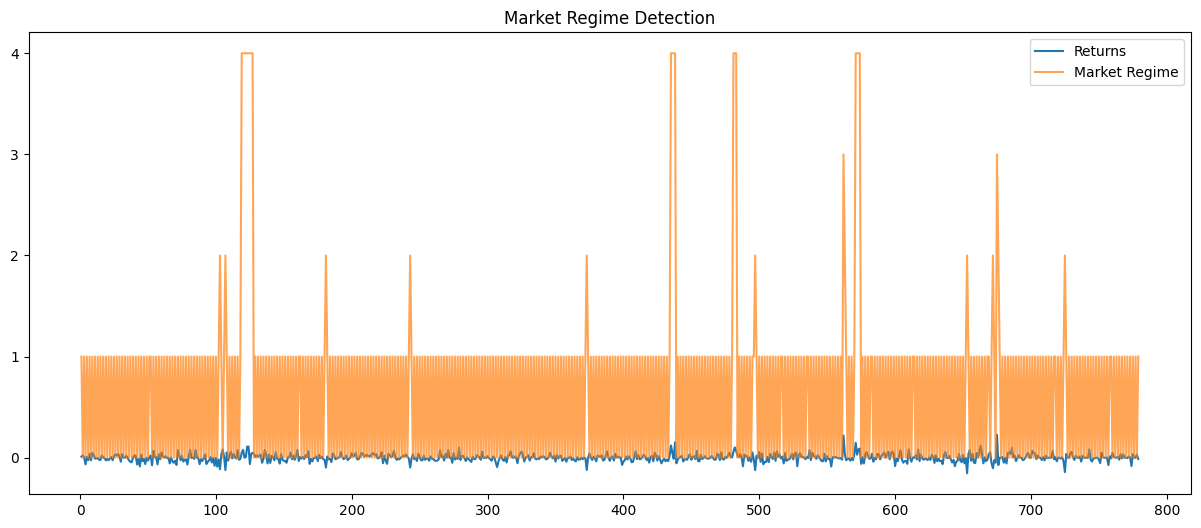

Training predictive model...
Epoch 1/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 2.9317 - quantile_0.05_loss: 0.6895 - quantile_0.25_loss: 0.6031 - quantile_0.5_loss: 0.5567 - quantile_0.75_loss: 0.6413 - quantile_0.95_loss: 0.4398

10/10 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - loss: 2.8948 - quantile_0.05_loss: 0.6755 - quantile_0.25_loss: 0.5960 - quantile_0.5_loss: 0.5541 - quantile_0.75_loss: 0.6340 - quantile_0.95_loss: 0.4330 - val_loss: 1.1276 - val_quantile_0.05_loss: 0.0799 - val_quantile_0.25_loss: 0.2963 - val_quantile_0.5_loss: 0.3651 - val_quantile_0.75_loss: 0.3305 - val_quantile_0.95_loss: 0.0696 - learning_rate: 5.0000e-05
Epoch 2/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.6844 - quantile_0.05_loss: 0.2456 - quantile_0.25_loss: 0.3649 - quantile_0.5_loss: 0.4539 - quantile_0.75_loss: 0.4048 - quantile_0.95_loss: 0.2150

10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 1.6780 - quantile_0.05_loss: 0.2437 - quantile_0.25_loss: 0.3641 - quantile_0.5_loss: 0.4532 - quantile_0.75_loss: 0.4032 - quantile_0.95_loss: 0.2133 - val_loss: 1.0602 - val_quantile_0.05_loss: 0.1186 - val_quantile_0.25_loss: 0.3238 - val_quantile_0.5_loss: 0.3292 - val_quantile_0.75_loss: 0.2538 - val_quantile_0.95_loss: 0.0454 - learning_rate: 5.0000e-05
Epoch 3/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 1.4104 - quantile_0.05_loss: 0.1565 - quantile_0.25_loss: 0.3206 - quantile_0.5_loss: 0.4118 - quantile_0.75_loss: 0.3525 - quantile_0.95_loss: 0.1689 - val_loss: 1.0732 - val_quantile_0.05_loss: 0.1231 - val_quantile_0.25_loss: 0.3167 - val_quantile_0.5_loss: 0.3357 - val_quantile_0.75_loss: 0.2564 - val_quantile_0.95_loss: 0.0538 - learning_rate: 5.0000e-05
Epoch 4/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 1.2724 - quantile_0.05_loss: 0.1325 - quantile_0.25_loss: 0.2859 - quantile_0.5_loss: 0.3795 - quantile_0.75_lo

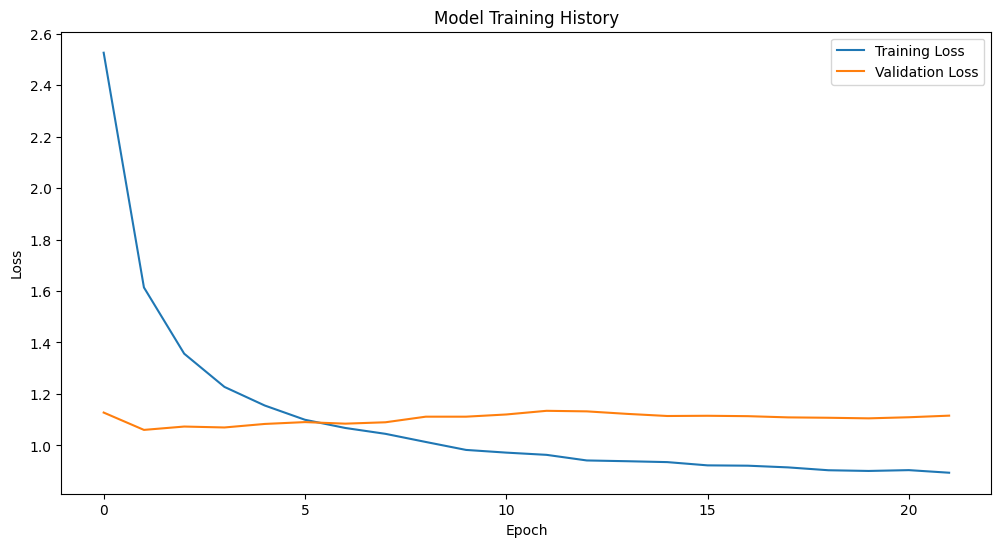


MODEL EVALUATION FOR TSLA
Test MAE: $74.96
Test RMSE: $82.96
Test MAPE: 23.56%
Mean Squared Error: 6882.1097
Error generating forecast plot: unsupported operand type(s) for +: 'int' and 'str'
Attempting to generate simplified plot...


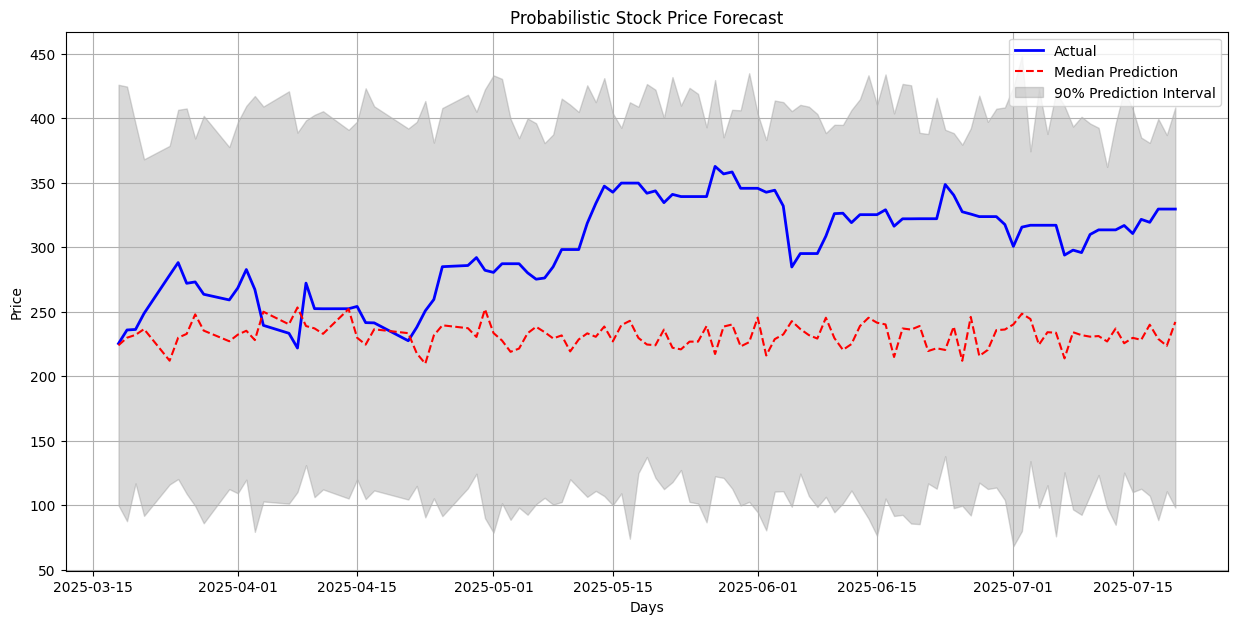


PREDICTION FOR NEXT 10 DAYS OF TSLA
Day 1 (2025-07-30):
  Median Prediction: $230.56
  90% Confidence: $113.94 - $394.49
Day 2 (2025-07-31):
  Median Prediction: $237.37
  90% Confidence: $91.69 - $358.90
Day 3 (2025-08-01):
  Median Prediction: $230.08
  90% Confidence: $102.37 - $392.35
Day 4 (2025-08-02):
  Median Prediction: $243.48
  90% Confidence: $28.90 - $377.82
Day 5 (2025-08-03):
  Median Prediction: $212.74
  90% Confidence: $44.92 - $356.32
Day 6 (2025-08-04):
  Median Prediction: $204.27
  90% Confidence: $69.91 - $433.39
Day 7 (2025-08-05):
  Median Prediction: $224.48
  90% Confidence: $98.49 - $472.47
Day 8 (2025-08-06):
  Median Prediction: $210.58
  90% Confidence: $134.89 - $424.27
Day 9 (2025-08-07):
  Median Prediction: $234.21
  90% Confidence: $135.66 - $375.35
Day 10 (2025-08-08):
  Median Prediction: $256.34
  90% Confidence: $131.97 - $365.85
Current Market Regime: 1
Saved new model to TSLA_model.h5 and TSLA_scaler.pkl

PREDICTION FOR NEXT 10 DAYS OF TSLA
Da

In [ ]:
# Segment 7: Complete Prediction System
class StockPredictionSystem:
    def __init__(self, ticker):
        self.ticker = ticker
        self.data_collector = DataCollector()
        self.feature_engineer = FeatureEngineer(ticker)
        self.regime_detector = RegimeDetector()
        self.scaler = RobustScaler()
        self.model = None
        self.prob_forecaster = None
        self.data = None
        self.X_test = None
        self.y_test = None
        self.test_dates = None

    def collect_and_prepare_data(self):
        print("Collecting data...")
        self.data = self.data_collector.get_stock_data(self.ticker)
        print(f"Raw data shape: {self.data.shape}")
        self.data = self.feature_engineer.add_features(self.data)

        # Clean data: Remove infs and NaNs
        self.data.replace([np.inf, -np.inf], np.nan, inplace=True)
        self.data.fillna(method='ffill', inplace=True)
        self.data.fillna(method='bfill', inplace=True)
        self.data.dropna(inplace=True)

        print(f"Final dataset shape: {self.data.shape}")
        return self.data

    def create_sequences(self, data):
        # Extract close prices for scaling
        close_prices = data[['Close']].values

        # Scale close prices
        scaled_close = self.scaler.fit_transform(close_prices)

        # Create sequences for multi-step forecasting
        X, y, dates = [], [], []
        for i in range(Config.LOOKBACK_WINDOW, len(data) - Config.PREDICTION_HORIZON + 1):
            # Get features - handle potential NaNs
            features = data.iloc[i-Config.LOOKBACK_WINDOW:i].drop(['date', 'Close'], axis=1, errors='ignore').values

            # Check for NaNs/Infs
            if np.isnan(features).any() or np.isinf(features).any():
                continue

            X.append(features)
            # Target is scaled close price for next HORIZON days, flattened to remove the trailing dimension
            y.append(scaled_close[i:i+Config.PREDICTION_HORIZON].flatten())
            dates.append(data['date'].iloc[i])

        # Convert to arrays and validate
        X = np.array(X)
        y = np.array(y)
        dates = np.array(dates)

        if len(X) == 0:
            raise ValueError("No valid sequences created. Check for NaN/Inf values in features.")

        print(f"Sequences created: X={X.shape}, y={y.shape}, dates={dates.shape}")
        return X, y, dates

    def train_regime_model(self):
        returns = self.data['Close'].pct_change()

        # Thoroughly clean the returns data
        returns.replace([np.inf, -np.inf], np.nan, inplace=True)
        returns.dropna(inplace=True)

        if len(returns) < 10:
            print("Warning: Insufficient data for regime detection. Skipping...")
            self.regime_detector.regime_labels = np.zeros(len(self.data))
            return self.regime_detector

        print("Training market regime detection model...")
        self.regime_detector.fit(returns)

        plt.figure(figsize=(15, 6))
        plt.plot(returns.index, returns, label='Returns')
        if len(self.regime_detector.regime_labels) == len(returns):
            plt.plot(returns.index, self.regime_detector.regime_labels,
                    label='Market Regime', alpha=0.7)
        plt.title('Market Regime Detection')
        plt.legend()
        plt.savefig(f"{Config.DATA_DIR}/plots/{self.ticker}_regime.png")
        plt.show()
        return self.regime_detector

    def train_predictive_model(self, X, y, dates):
        split_idx = int(len(X) * (1 - Config.TEST_SIZE))
        X_train, X_val = X[:split_idx], X[split_idx:]
        y_train, y_val = y[:split_idx], y[split_idx:]
        self.X_test = X_val
        self.y_test = y_val
        self.test_dates = dates[split_idx:]

        input_shape = (Config.LOOKBACK_WINDOW, X.shape[2])
        self.model = create_transformer_lstm_model(input_shape)

        callbacks = [
            EarlyStopping(patience=Config.PATIENCE, restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(factor=0.5, patience=Config.PATIENCE//2, verbose=1),
            ModelCheckpoint(f'{self.ticker}_best_model.h5', save_best_only=True)
        ]

        # Use a dictionary to explicitly map targets to outputs
        y_train_quantiles = {f'quantile_{q}': y_train for q in Config.QUANTILES}
        y_val_quantiles = {f'quantile_{q}': y_val for q in Config.QUANTILES}

        print("Training predictive model...")
        history = self.model.fit(
            X_train, y_train_quantiles,
            validation_data=(X_val, y_val_quantiles),
            epochs=Config.EPOCHS,
            batch_size=Config.BATCH_SIZE,
            callbacks=callbacks,
            verbose=1
        )

        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Training History')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        plt.savefig(f"{Config.DATA_DIR}/plots/{self.ticker}_training.png")
        plt.show()

        self.prob_forecaster = ProbabilisticForecaster(self.model, self.scaler)
        return self.model


    def evaluate_model(self):
        if self.X_test is None or self.y_test is None or self.prob_forecaster is None:
             print("Evaluation skipped: Test data or forecaster not available.")
             return None, None, None

        quantile_preds = self.prob_forecaster.monte_carlo_predict(self.X_test)

        # Inverse transform actuals
        y_actual = self.scaler.inverse_transform(self.y_test.reshape(-1, 1)).reshape(self.y_test.shape)

        median_pred = quantile_preds[0.5]['mean']
        mae = mean_absolute_error(y_actual.flatten(), median_pred.flatten())
        rmse = np.sqrt(mean_squared_error(y_actual.flatten(), median_pred.flatten()))
        # Ensure y_actual is not zero to avoid division by zero in MAPE
        mape = np.mean(np.abs((y_actual.flatten() - median_pred.flatten()) / np.maximum(y_actual.flatten(), 1e-8))) * 100
        mse = mean_squared_error(y_actual.flatten(), median_pred.flatten())


        print(f"\n{'='*50}")
        print(f"MODEL EVALUATION FOR {self.ticker}")
        print(f"{'='*50}")
        print(f"Test MAE: ${mae:.2f}")
        print(f"Test RMSE: ${rmse:.2f}")
        print(f"Test MAPE: {mape:.2f}%")
        print(f"Mean Squared Error: {mse:.4f}")

        # Convert y_true to float
        y_actual_float = y_actual[:, 0].astype(float)

        self.prob_forecaster.plot_probabilistic_forecast(self.test_dates, y_actual_float, quantile_preds)
        return mae, rmse, mape

    def predict_next_days(self):
        if self.prob_forecaster is None or self.data is None:
             print("Prediction skipped: Forecaster or data not available.")
             return None

        latest_data = self.data.iloc[-Config.LOOKBACK_WINDOW:]
        X = latest_data.drop(['date', 'Close'], axis=1, errors='ignore').values
        X = X.reshape(1, Config.LOOKBACK_WINDOW, -1)

        quantile_preds = self.prob_forecaster.monte_carlo_predict(X)

        latest_return = self.data['Close'].pct_change().iloc[-1]
        current_regime = self.regime_detector.get_current_regime(latest_return)

        return {
            '5th_percentile': quantile_preds[0.05]['mean'].flatten(),
            'median': quantile_preds[0.5]['mean'].flatten(),
            '95th_percentile': quantile_preds[0.95]['mean'].flatten(),
            'regime': current_regime
        }

    def plot_technical_indicators(self):
        if self.data is None or self.data.empty:
            print("Technical indicator plot skipped: No data available.")
            return
        # Create interactive technical indicator plots
        fig = make_subplots(rows=3, cols=1, shared_xaxes=True,
                          vertical_spacing=0.05,
                          row_heights=[0.6, 0.2, 0.2])

        # Price and moving averages
        fig.add_trace(go.Scatter(
            x=self.data['date'], y=self.data['Close'],
            name='Close', line=dict(color='blue')), row=1, col=1)
        fig.add_trace(go.Scatter(
            x=self.data['date'], y=self.data['sma_50'],
            name='SMA 50', line=dict(color='orange')), row=1, col=1)
        fig.add_trace(go.Scatter(
            x=self.data['date'], y=self.data['sma_200'],
            name='SMA 200', line=dict(color='purple')), row=1, col=1)

        # MACD
        if 'macd' in self.data.columns and 'macd_signal' in self.data.columns:
            fig.add_trace(go.Scatter(
                x=self.data['date'], y=self.data['macd'],
                name='MACD', line=dict(color='blue')), row=2, col=1)
            fig.add_trace(go.Scatter(
                x=self.data['date'], y=self.data['macd_signal'],
                name='Signal', line=dict(color='red')), row=2, col=1)
        else:
             print("MACD data not available for plotting.")


        # RSI
        if 'rsi' in self.data.columns:
            fig.add_trace(go.Scatter(
                x=self.data['date'], y=self.data['rsi'],
                name='RSI', line=dict(color='green')), row=3, col=1)
            fig.add_hline(y=30, row=3, col=1, line=dict(color="red", width=1, dash="dash"))
            fig.add_hline(y=70, row=3, col=1, line=dict(color="red", width=1, dash="dash"))
        else:
            print("RSI data not available for plotting.")

        fig.update_layout(
            title=f'{self.ticker} Technical Indicators',
            height=800,
            showlegend=True
        )

        fig.write_image(f"{Config.DATA_DIR}/plots/{self.ticker}_technical.png")
        fig.show()

    def run_full_pipeline(self):
        data = self.collect_and_prepare_data()
        X, y, dates = self.create_sequences(data)

        if Config.USE_REGIME_DETECTION:
            self.train_regime_model()

        self.train_predictive_model(X, y, dates)

        # Check if prob_forecaster was successfully initialized after training
        if self.prob_forecaster is None:
            raise RuntimeError("Predictive model training failed.")

        self.plot_technical_indicators()
        test_mae, test_rmse, test_mape = self.evaluate_model()

        prediction = self.predict_next_days()
        forecast_dates = pd.date_range(
            start=self.data['date'].iloc[-1] + timedelta(days=1),
            periods=Config.PREDICTION_HORIZON
        )

        print(f"\n{'='*50}")
        print(f"PREDICTION FOR NEXT {Config.PREDICTION_HORIZON} DAYS OF {self.ticker}")
        print(f"{'='*50}")
        if prediction is not None:
            for i in range(Config.PREDICTION_HORIZON):
                print(f"Day {i+1} ({forecast_dates[i].strftime('%Y-%m-%d')}):")
                print(f"  Median Prediction: ${prediction['median'][i]:.2f}")
                print(f"  90% Confidence: ${prediction['5th_percentile'][i]:.2f} - ${prediction['95th_percentile'][i]:.2f}")
            print(f"Current Market Regime: {prediction['regime']}")
        else:
            print("Prediction could not be generated due to previous errors.")

        return prediction

# Segment 8: Main Execution with Robust Model Loading
# Re-define quantile_loss and QuantileLoss to ensure they are available
def quantile_loss(q, y_true, y_pred):
    e = y_true - y_pred
    return tf.reduce_mean(tf.maximum(q * e, (q - 1) * e))

class QuantileLoss(tf.keras.losses.Loss):
    def __init__(self, q, name="quantile_loss"):
        super().__init__(name=name)
        self.q = q

    def call(self, y_true, y_pred):
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.cast(y_true, y_pred.dtype)
        e = y_true - y_pred
        return tf.reduce_mean(tf.maximum(self.q * e, (self.q - 1) * e))

    def get_config(self):
        config = super().get_config()
        config.update({"q": self.q})
        return config

if __name__ == "__main__":
    ticker = input("Enter stock ticker (e.g., AAPL): ").strip().upper()
    horizon = int(input("Enter prediction horizon (days, default 10): ").strip() or "10")
    Config.PREDICTION_HORIZON = horizon

    print(f"\n{'='*50}")
    print(f"INITIALIZING ADVANCED STOCK PREDICTION SYSTEM FOR {ticker}")
    print(f"PREDICTION HORIZON: {horizon} DAYS")
    print(f"{'='*50}\n")

    system = StockPredictionSystem(ticker)

    # Define model and scaler filenames
    model_file = f'{ticker}_model.h5'
    scaler_file = f'{ticker}_scaler.pkl'

    # Define custom objects for loading, outside the try block
    custom_objects = {
        'QuantileLoss': QuantileLoss, # Use the class directly
        **{f'quantile_{q}': QuantileLoss(q).call for q in Config.QUANTILES} # Use instance call for direct function access if needed, though class name should be sufficient
    }


    # Check if model exists and ask user
    skip_training = False
    if os.path.exists(model_file) and os.path.exists(scaler_file):
        choice = input("Found existing model. Skip training and use saved model? (yes/no): ").strip().lower()
        if choice in ['yes', 'y']:
            skip_training = True
            print("Skipping training... Loading saved model")

    if skip_training:
        # Load existing model with proper custom objects
        try:
            # Ensure custom_objects is available here
            if 'custom_objects' not in locals():
                 custom_objects = {
                    'QuantileLoss': QuantileLoss,
                    **{f'quantile_{q}': QuantileLoss(q).call for q in Config.QUANTILES}
                 }


            system.model = load_model(
                model_file,
                custom_objects=custom_objects,
                compile=False # Load without compiling to avoid custom object issues during loading
            )
            # Recompile the model after loading with the correct losses
            losses = {f'quantile_{q}': QuantileLoss(q) for q in Config.QUANTILES}
            optimizer = Nadam(learning_rate=Config.LEARNING_RATE)
            system.model.compile(optimizer=optimizer, loss=losses)


            system.scaler = joblib.load(scaler_file)
            system.prob_forecaster = ProbabilisticForecaster(system.model, system.scaler)

            # Collect fresh data for prediction context
            system.collect_and_prepare_data()
            X, y, dates = system.create_sequences(system.data)
            split_idx = int(len(X) * (1 - Config.TEST_SIZE))
            system.X_test = X[split_idx:]
            system.y_test = y[split_idx:]
            system.test_dates = dates[split_idx:] # Ensure test_dates is set


            # Generate plots
            system.plot_technical_indicators()

            try:
                system.evaluate_model()
            except Exception as e:
                print(f"Evaluation error: {str(e)}")
                print("Proceeding with prediction anyway...")

        except Exception as e:
            print(f"Error loading saved model: {str(e)}")
            print("Falling back to training new model...")
            skip_training = False
            # If loading fails, ensure forecaster is None so training happens
            system.prob_forecaster = None


    if not skip_training:
        # Run full training pipeline
        try:
            system.run_full_pipeline()
            # Save new model
            if system.model is not None and system.scaler is not None:
                 system.model.save(model_file)
                 joblib.dump(system.scaler, scaler_file)
                 print(f"Saved new model to {model_file} and {scaler_file}")
            else:
                 print("Model or scaler not available after training, skipping save.")

        except Exception as e:
            print(f"Training error: {str(e)}")
            # If training fails, check if prob_forecaster is None.
            # If it is, then raise a RuntimeError.
            if system.prob_forecaster is None:
                raise RuntimeError(f"Predictive model training failed: {str(e)}") from e
            else:
                print("Partial training succeeded, attempting to proceed.")


    # After attempts to load or train, check if the forecaster is available
    if system.prob_forecaster is None:
         raise RuntimeError("Failed to load or train the predictive model.")

    # Make prediction with either new or saved model
    prediction = system.predict_next_days()
    if prediction is not None:
        forecast_dates = pd.date_range(
            start=system.data['date'].iloc[-1] + timedelta(days=1),
            periods=Config.PREDICTION_HORIZON
        )

        print(f"\n{'='*50}")
        print(f"PREDICTION FOR NEXT {Config.PREDICTION_HORIZON} DAYS OF {ticker}")
        print(f"{'='*50}")
        for i in range(Config.PREDICTION_HORIZON):
            print(f"Day {i+1} ({forecast_dates[i].strftime('%Y-%m-%d')}):")
            print(f"  Median Prediction: ${prediction['median'][i]:.2f}")
            print(f"  90% Confidence: ${prediction['5th_percentile'][i]:.2f} - ${prediction['95th_percentile'][i]:.2f}")
        print(f"Current Market Regime: {prediction['regime']}")
    else:
         print("\nPrediction could not be generated.")


    print("\nProcess completed successfully!" if prediction is not None else "\nProcess finished with errors.")